In [1]:
from __future__ import print_function
#%matplotlib inline

import os
import random
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn.functional as F
from IPython import display
from torchvision.utils import save_image, make_grid


import warnings
warnings.filterwarnings('ignore')

In [2]:
batch_size = 16
image_size = 28
num_channels = 1 # количество слоев
latent_layer = 100 # размер скрытого слоя

num_feats_gen = 32 # Количество фич в генераторе
num_feats_disc = 32 # Количество фич в дискриминаторе

num_epochs = 5
lr = 0.0002

beta1 = 0.5 #для оптимайзера Adam

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

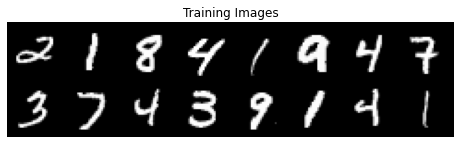

In [5]:
# Plot some training images
real_batch = next(iter(real_data))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Инициализация весов из нормального распределения с mean=0, stdev=0.02

In [6]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

#### Генератор

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_layer, 64*7*7)
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 64, 7, 7)
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        
        return x

#### Дискриминатор

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, 2, 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 1)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x) 
        x = self.batch2(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(-1, 64*7*7)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        return x

In [9]:
n_epochs = 20 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [11]:
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 19/20] [Batch 3725/3750] [D loss: 0.191004] [G loss: 2.370447]


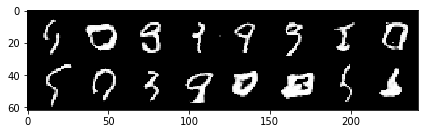

<Figure size 432x288 with 0 Axes>

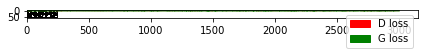

In [12]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)
#         print('real_imgs', real_imgs.size())


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
#         z = torch.randn(64, latent_layer, 28, 28, device=device)
#         print('z',  z.size())
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
#         print('gen_imgs', gen_imgs.size())
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
#         print('real_pred', real_pred.size())
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            